In [1]:
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection
from ithor_tools.map import single_scenemap
from ithor_tools.astar import astar
import random
import math
from IPython.display import display
from moviepy.editor import ImageSequenceClip,VideoFileClip
from matplotlib import transforms


"AI2-THOR Version: " + ai2thor.__version__

'AI2-THOR Version: 4.2.0'

In [2]:
gridSize=0.05

controller = Controller(
    # platform = CloudRendering,
    agentMode="locobot",
    visibilityDistance=1.5,
    scene="FloorPlan_Train1_3",
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=500,
    height=500,
    fieldOfView=60
)

In [3]:
controller.reset(
    # makes the images a bit higher quality
    width=400,
    height=400,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)


<ai2thor.server.Event at 0x7f38b65c68b0
    .metadata["lastAction"] = Initialize
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}
>

In [4]:
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize=5, # size of output image
    skyboxColor="white",
    fieldOfView = 90
)


<ai2thor.server.Event at 0x7f38b5e60910
    .metadata["lastAction"] = AddThirdPartyCamera
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [5]:
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

initstate = 20
goalstate = 4000

controller.step(
    action="Teleport",
    position = rstate[initstate]
)


<ai2thor.server.Event at 0x7f3865b0f2e0
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

## GridMap RRT

In [6]:
from RRT import gridmaprrt as rrt

In [7]:
rrtplanner = rrt.RRT(controller = controller, expand_dis=0.1,max_iter=10000,goal_sample_rate=20)
rrtplanner.set_start(rstate[initstate])
rrtplanner.set_goal(rstate[goalstate])

In [14]:
%matplotlib tk
path = rrtplanner.planning(animation=True) # Uncomment "%matplotlib tk" when you want to animate

KeyboardInterrupt: 

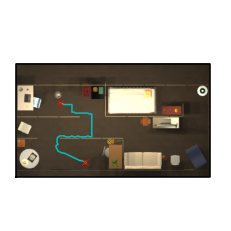

In [9]:
%matplotlib inline
rrtplanner.plot_path(path)

In [10]:
%matplotlib tk
from RRT import gridmaprrt_pathsmoothing as smoothing
smoothpath = smoothing.path_smoothing(rrtplanner,40,verbose=False)

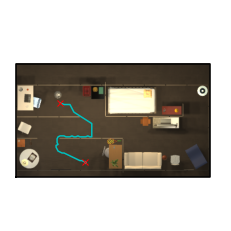

In [11]:
%matplotlib inline
rrtplanner.plot_path(smoothpath)

In [13]:
flag,frames = rrtplanner.go_with_teleport(smoothpath,maxspeed=0.2)

MoviePy - Building file temp.gif with imageio.


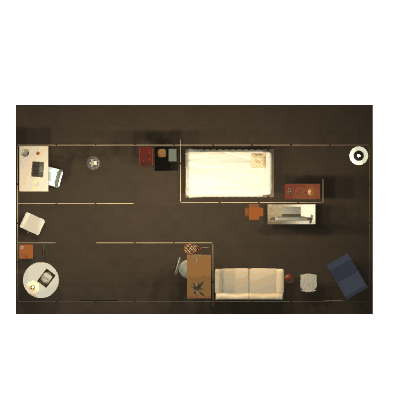

In [16]:
video = ImageSequenceClip(frames, fps=10)
video.write_gif('temp.gif')

from IPython.display import Image as IM
with open('temp.gif','rb') as file:
    display(IM(file.read(),width = 300))

## Move doesn't always go to reachable space

In [8]:
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']


In [9]:
def verify_pos(rstate, pos):
    np_rstate = []
    for state in rstate:
        temp = [state['x'],state['z']]
        np_rstate.append(temp)
    np_rstate = np.array(np_rstate)
    
    pos = np.array([pos['x'], pos['z']])

    
    
    np_rstate = np_rstate - pos
    # print(np_rstate.shape)
    
    np_state_norm = np.linalg.norm(np_rstate, axis = 1)
    idx = np.argmin(np_state_norm)
    
    smallest_error = np_rstate[idx,:]
    
    return idx, smallest_error

In [10]:
mag = random.random() * 0.1
rot = random.random() * 10
controller.step(action='MoveAhead', moveMagnitude=mag)
controller.step(action='RotateRight', degrees=rot)
pos = controller.last_event.metadata['agent']['position']

idx, smallest_error = verify_pos(rstate, pos)

smallest_error

array([2.38418579e-07, 0.00000000e+00])

## Rotating error

In [117]:
crot = controller.last_event.metadata['agent']['rotation']
crot

{'x': -0.0, 'y': 138.7446746826172, 'z': -0.0}

In [118]:
controller.step(action='RotateRight', degrees=0)
crot = controller.last_event.metadata['agent']['rotation']
crot

{'x': -0.0, 'y': 138.99612426757812, 'z': -0.0}